<a href="https://colab.research.google.com/github/Owusuk/Projects/blob/main/Stock_Price_Prediction2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install vaderSentiment
%pip install keras
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Tweeter Data

tweets_df = pd.read_excel('/content/drive/MyDrive/Projects/NLP_Project/Project/appleTweets.xlsx')
tweets_df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,Place (as appears on Bio),Followers,Following,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,NaN,375.0,431.0,29.0,en,False,NaN,NaN,$AAPL
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,NaN,1.0,CA,Canada,545.0,771.0,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq"
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,NaN,NaN,NaN,NaN,1058.0,170.0,67.0,en,False,@RPatel83,NaN,$AAPL
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,NaN,NaN,GB,London,817.0,885.0,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR"
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,NaN,NaN,NaN,NaN,1785.0,22.0,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74796,716328052892897280,2016-04-02,18:14,Daniel,LeRatton,~ Tucson #WankPuffin,“And in a world where you get a huge cheer fro...,NaN,NaN,NaN,NaN,1602.0,2029.0,108.0,en,False,NaN,NaN,$AAPL
74797,716327961641680898,2016-04-02,18:14,Computer News,computer_hware,Track all of the latest Computer News with Owl...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,24.0,2.0,38.0,en,False,NaN,#Apple,$AAPL
74798,716327961641639937,2016-04-02,18:14,Peripheral News,_peripherals,Track all of the latest Peripheral News with O...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,27.0,3.0,38.0,en,False,NaN,#Apple,$AAPL
74799,716326132476461058,2016-04-02,18:07,Baylee Pulliam,BayleePulliam,#Writer. #Ideator. #Digital Native. Would beat...,Here's why #Apple is flying a pirate flag to c...,NaN,NaN,US,"Louisville, Kentucky",1836.0,967.0,293.0,en,False,NaN,#Apple,$AAPL


In [ ]:
#@title Stock Data

stock_df = pd.read_csv('/content/drive/MyDrive/Projects/NLP_Project/Project/appleStock201604.csv')
stock_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2016-04-04,25.632113,26.042989,25.597293,25.794607,149424800,0,0
1,2016-04-05,25.420874,25.704076,25.399981,25.490513,106314800,0,0
2,2016-04-06,25.588007,25.762107,25.348909,25.757463,105616400,0,0
3,2016-04-07,25.523008,25.632111,25.098206,25.195702,127207600,0,0
4,2016-04-08,25.281594,25.481226,25.109814,25.223560,94326800,0,0
5,2016-04-11,25.295525,25.676223,25.263027,25.307131,117630000,0,0
6,2016-04-12,25.381409,25.650684,25.223561,25.636757,108929200,0,0
7,2016-04-13,25.720327,26.077810,25.720327,26.008171,133029200,0,0
8,2016-04-14,25.910676,26.089417,25.843357,26.022099,101895600,0,0
9,2016-04-15,26.024421,26.068526,25.471945,25.499800,187756000,0,0


In [ ]:
stock_df.shape

(20, 8)

In [ ]:
#@title Data Preprocessing

# Function for tweet preprocessing

def preprocess_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\W|\d', ' ', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply tweet preprocessing
tweets_df['Cleaned Tweet'] = tweets_df['Tweet content'].apply(preprocess_tweet)
tweets_df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,Place (as appears on Bio),Followers,Following,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols,Cleaned Tweet
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,NaN,375.0,431.0,29.0,en,False,NaN,NaN,$AAPL,aapl management and ceo infographic
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,NaN,1.0,CA,Canada,545.0,771.0,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq",the criminal media does fools investors once a...
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,NaN,NaN,NaN,NaN,1058.0,170.0,67.0,en,False,@RPatel83,NaN,$AAPL,rpatel ha it s ok i ve been very clear since t...
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,NaN,NaN,GB,London,817.0,885.0,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR",monitor your watchlist of assets for tweets us...
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,NaN,NaN,NaN,NaN,1785.0,22.0,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR",new post analysis trade ideas aapl tsla amzn n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74796,716328052892897280,2016-04-02,18:14,Daniel,LeRatton,~ Tucson #WankPuffin,“And in a world where you get a huge cheer fro...,NaN,NaN,NaN,NaN,1602.0,2029.0,108.0,en,False,NaN,NaN,$AAPL,and in a world where you get a huge cheer from...
74797,716327961641680898,2016-04-02,18:14,Computer News,computer_hware,Track all of the latest Computer News with Owl...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,24.0,2.0,38.0,en,False,NaN,#Apple,$AAPL,why intel is supporting apple s iphone read mo...
74798,716327961641639937,2016-04-02,18:14,Peripheral News,_peripherals,Track all of the latest Peripheral News with O...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,27.0,3.0,38.0,en,False,NaN,#Apple,$AAPL,why intel is supporting apple s iphone read mo...
74799,716326132476461058,2016-04-02,18:07,Baylee Pulliam,BayleePulliam,#Writer. #Ideator. #Digital Native. Would beat...,Here's why #Apple is flying a pirate flag to c...,NaN,NaN,US,"Louisville, Kentucky",1836.0,967.0,293.0,en,False,NaN,#Apple,$AAPL,here s why apple is flying a pirate flag to ce...


In [ ]:
#@title Remove Duplicate Twitter Messages

# Check duplicates for Tweet content

print('Duplicate Content Count=', tweets_df[['Cleaned Tweet']].duplicated().sum())

# Remove duplicate

print("Original Row # :", tweets_df.shape[0])
tweets_df = tweets_df.drop_duplicates(subset='Cleaned Tweet', keep='first')
print("Row After Removed Duplicates # :", tweets_df.shape[0])

Duplicate Content Count= 34760
Original Row # : 74801
Row After Removed Duplicates # : 40041


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Tokenization

stop_words = nltk.corpus.stopwords.words('english')
tokenizer = word_tokenize

tweet_text = []

for index, row in tweets_df.iterrows():
    text = row['Cleaned Tweet']

    if not text or len(text) == 0:
        tweet_text.append("")
        continue

    words = tokenizer(text.lower())
    clean_words = []

    for word in words:
        if word in stop_words or word in string.punctuation or "/" in word:
            continue
        clean_words.append(word)

        # Rejoin the clean words into a single string
    preprocessed_text = " ".join(clean_words)

    tweet_text.append(preprocessed_text)

    # Add the preprocessed text as a new column in the DataFrame
tweets_df['preprocessed_tweet'] = tweet_text

# View the first 5 preprocessed reviews
print(tweets_df[['Cleaned Tweet', 'preprocessed_tweet']].head())

                                       Cleaned Tweet  \
0                aapl management and ceo infographic   
1  the criminal media does fools investors once a...   
2  rpatel ha it s ok i ve been very clear since t...   
3  monitor your watchlist of assets for tweets us...   
4  new post analysis trade ideas aapl tsla amzn n...   

                                  preprocessed_tweet  
0                    aapl management ceo infographic  
1  criminal media fools investors aapl spy qqq ba...  
2  rpatel ha ok clear since aapl sell got plenty ...  
3  monitor watchlist assets tweets us tech giants...  
4  new post analysis trade ideas aapl tsla amzn n...  


In [ ]:
# Filter tweets by a minimum number of followers

MIN_FOLLOWERS = 100
tweets_df = tweets_df[tweets_df['Followers'] >= MIN_FOLLOWERS]
tweets_df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,...,Followers,Following,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols,Cleaned Tweet,preprocessed_tweet
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,...,375.0,431.0,29.0,en,False,NaN,NaN,$AAPL,aapl management and ceo infographic,aapl management ceo infographic
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,NaN,1.0,CA,...,545.0,771.0,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq",the criminal media does fools investors once a...,criminal media fools investors aapl spy qqq ba...
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,NaN,NaN,NaN,...,1058.0,170.0,67.0,en,False,@RPatel83,NaN,$AAPL,rpatel ha it s ok i ve been very clear since t...,rpatel ha ok clear since aapl sell got plenty ...
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,NaN,NaN,GB,...,817.0,885.0,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR",monitor your watchlist of assets for tweets us...,monitor watchlist assets tweets us tech giants...
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,NaN,NaN,NaN,...,1785.0,22.0,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR",new post analysis trade ideas aapl tsla amzn n...,new post analysis trade ideas aapl tsla amzn n...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74792,716328551935557632,2016-04-02,18:16,DonaldOJDK,DonaldOJDK,"OpenJDK, Java SE, Security and Open Source. N...",It's looking like $aapl should still be a buy....,NaN,NaN,CA,...,1503.0,256.0,75.0,en,False,NaN,NaN,$aapl,it s looking like aapl should still be a buy,looking like aapl still buy
74794,716328320518856704,2016-04-02,18:15,Kevin C. Bell,Kevin_C_Bell,Student | iOS Mobile Developer | Bloc.io Appre...,&gt; $AAPL celebrates 40th anniversary with Be...,NaN,NaN,NaN,...,2768.0,2762.0,279.0,en,False,NaN,NaN,$AAPL,gt aapl celebrates th anniversary with beer ba...,gt aapl celebrates th anniversary beer bash dj...
74795,716328283881807872,2016-04-02,18:15,RT,RTAutomator,"Entrepreneur, Wall Street, Boston Sports Fan, ...",@damon @devinsays iPhone growth will be there ...,1.0,NaN,NaN,...,105.0,330.0,17.0,en,False,"@damon,@devinsays",NaN,$aapl,damon devinsays iphone growth will be there wi...,damon devinsays iphone growth se amp watch win...
74796,716328052892897280,2016-04-02,18:14,Daniel,LeRatton,~ Tucson #WankPuffin,“And in a world where you get a huge cheer fro...,NaN,NaN,NaN,...,1602.0,2029.0,108.0,en,False,NaN,NaN,$AAPL,and in a world where you get a huge cheer from...,world get huge cheer audience announced nylon ...


In [ ]:
# Define VADER sentiment analysis
vader_analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    vader_score = vader_analyzer.polarity_scores(text)
    return vader_score['compound']  # Use compound score for overall sentiment

In [ ]:
# Apply VADER sentiment analysis
tweets_df['VADER Sentiment'] = tweets_df['preprocessed_tweet'].apply(get_vader_sentiment)

# Calculate weighted sentiment based on engagement
tweets_df['Favs'] = tweets_df['Favs'].fillna(0)
tweets_df['RTs'] = tweets_df['RTs'].fillna(0)
tweets_df['Weighted VADER Sentiment'] = tweets_df['VADER Sentiment'] * (tweets_df['Favs'] + tweets_df['RTs'] + 1)
tweets_df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,...,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols,Cleaned Tweet,preprocessed_tweet,VADER Sentiment,Weighted VADER Sentiment
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,...,29.0,en,False,NaN,NaN,$AAPL,aapl management and ceo infographic,aapl management ceo infographic,0.0000,0.0000
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,0.0,1.0,CA,...,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq",the criminal media does fools investors once a...,criminal media fools investors aapl spy qqq ba...,-0.7650,-1.5300
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,0.0,0.0,NaN,...,67.0,en,False,@RPatel83,NaN,$AAPL,rpatel ha it s ok i ve been very clear since t...,rpatel ha ok clear since aapl sell got plenty ...,0.4588,0.4588
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,0.0,0.0,GB,...,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR",monitor your watchlist of assets for tweets us...,monitor watchlist assets tweets us tech giants...,0.1779,0.1779
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,0.0,0.0,NaN,...,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR",new post analysis trade ideas aapl tsla amzn n...,new post analysis trade ideas aapl tsla amzn n...,0.2732,0.2732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74792,716328551935557632,2016-04-02,18:16,DonaldOJDK,DonaldOJDK,"OpenJDK, Java SE, Security and Open Source. N...",It's looking like $aapl should still be a buy....,0.0,0.0,CA,...,75.0,en,False,NaN,NaN,$aapl,it s looking like aapl should still be a buy,looking like aapl still buy,0.3612,0.3612
74794,716328320518856704,2016-04-02,18:15,Kevin C. Bell,Kevin_C_Bell,Student | iOS Mobile Developer | Bloc.io Appre...,&gt; $AAPL celebrates 40th anniversary with Be...,0.0,0.0,NaN,...,279.0,en,False,NaN,NaN,$AAPL,gt aapl celebrates th anniversary with beer ba...,gt aapl celebrates th anniversary beer bash dj...,0.7430,0.7430
74795,716328283881807872,2016-04-02,18:15,RT,RTAutomator,"Entrepreneur, Wall Street, Boston Sports Fan, ...",@damon @devinsays iPhone growth will be there ...,1.0,0.0,NaN,...,17.0,en,False,"@damon,@devinsays",NaN,$aapl,damon devinsays iphone growth will be there wi...,damon devinsays iphone growth se amp watch win...,0.7184,1.4368
74796,716328052892897280,2016-04-02,18:14,Daniel,LeRatton,~ Tucson #WankPuffin,“And in a world where you get a huge cheer fro...,0.0,0.0,NaN,...,108.0,en,False,NaN,NaN,$AAPL,and in a world where you get a huge cheer from...,world get huge cheer audience announced nylon ...,0.6808,0.6808


In [ ]:
# Aggregate weighted sentiment by date

daily_sentiment = tweets_df.groupby('Date')['Weighted VADER Sentiment'].mean().reset_index()
daily_sentiment

,Date,Weighted VADER Sentiment
0,2016-04-02,0.343057
1,2016-04-03,0.256463
2,2016-04-04,0.395425
3,2016-04-05,0.288271
4,2016-04-06,0.353708
5,2016-04-07,0.333850
6,2016-04-08,0.497494
7,2016-04-09,0.268931
8,2016-04-10,0.156151
9,2016-04-11,0.352901


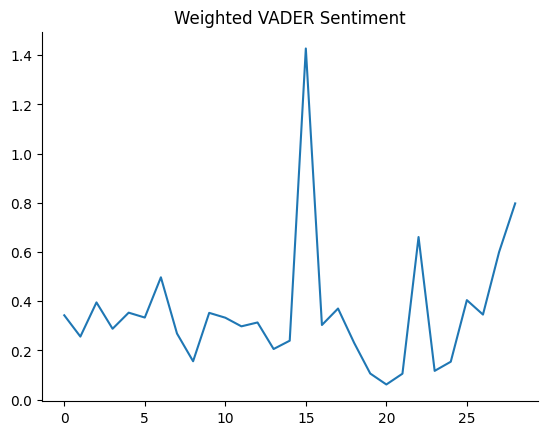

In [ ]:
#@title Visualization of the Weighted Scores

daily_sentiment['Weighted VADER Sentiment'].plot(kind='line', title='Weighted VADER Sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def label_compound(compound_value):
    if compound_value >= 0:
        return 'pos'
    else:
        return 'neg'

tweets_df['comp_score_2'] = tweets_df['Weighted VADER Sentiment'].apply(label_compound)

# View the first 5 rows with the new comp_score column
print(tweets_df.head())

             Tweet Id        Date   Hour          User Name         Nickname  \
0  726561352882524160  2016-04-30  23:58  Warren of Wall St   WarrenofWallSt   
1  726560818683215872  2016-04-30  23:56    AlejandroMasari  AlejandroDinero   
2  726560521076396032  2016-04-30  23:55       Cody Freeman        ZenTrends   
3  726559661718179844  2016-04-30  23:51            FinBuzz    PortfolioBuzz   
4  726559467353964545  2016-04-30  23:50             Taylor  Trading_Analyst   

                                                 Bio  \
0  Warren is the @SimplyWallSt mascot who helps y...   
1  Passionate about coaching & teaching clients h...   
2                                                NaN   
3  Financial #bigdata crowd-sourced, crowd-curate...   
4  -------- CMT Level II Candidate  ------- The m...   

                                       Tweet content  Favs  RTs Country  ...  \
0  $AAPL management and CEO infographic https://t...   1.0  1.0     NaN  ...   
1  the criminal media 

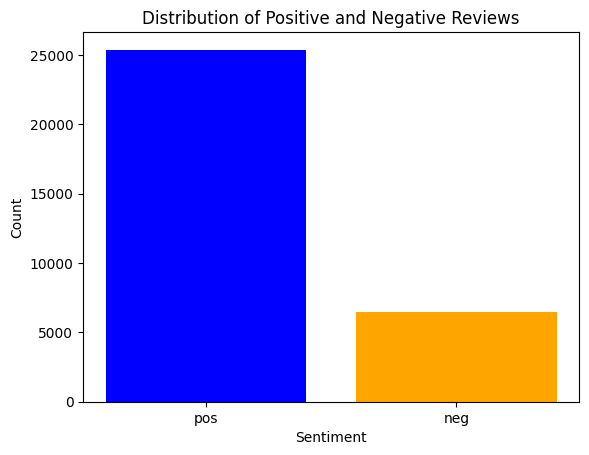

In [ ]:
# Count the number of positive and negative reviews

sentiment_counts = tweets_df['comp_score_2'].value_counts()

# Create a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=["blue", "orange"])
plt.title("Distribution of Positive and Negative Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=range(len(sentiment_counts.index)), labels=sentiment_counts.index)
plt.show()

In [ ]:
#@title Remove Duplicate Stock Data


# Check Duplicates for stock_df

print('Duplicate Date Count=', stock_df.duplicated().sum())

# Remove duplicate

print("Original Row # :", stock_df.shape[0])
stock_df = stock_df.drop_duplicates(subset='Date', keep='first')
print("Row After Removed Duplicates # :", stock_df.shape[0])

Duplicate Date Count= 0
Original Row # : 20
Row After Removed Duplicates # : 20


In [ ]:
#@title Descriptive Statistics

stock_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.0,20.0
mean,24.765331,24.988411,24.545269,24.739913,1.693019e+08,0.0,0.0
std,1.203234,1.181613,1.265467,1.236979,9.374135e+07,0.0,0.0
min,21.818171,21.987629,21.474615,21.760138,9.432680e+07,0.0,0.0
25%,24.375699,24.669347,24.279364,24.496988,1.113271e+08,0.0,0.0
50%,25.279275,25.386055,24.961252,25.072676,1.283736e+08,0.0,0.0
75%,25.539258,25.718584,25.361677,25.534039,1.968332e+08,0.0,0.0
max,26.024421,26.089417,25.843357,26.022099,4.584084e+08,0.0,0.0


In [ ]:
#@title Stock Price Daily Movement and Weighted Sentiment

# Calculate price changes in the stock data
stock_df['Price Change'] = (stock_df['Close'] - stock_df['Open']) / stock_df['Open']

# Merge the sentiment data with stock price changes
merged_df = pd.merge(stock_df[['Date', 'Price Change']], daily_sentiment, on='Date', how='inner')
merged_df

,Date,Price Change,Weighted VADER Sentiment
0,2016-04-04,0.006339,0.395425
1,2016-04-05,0.002739,0.288271
2,2016-04-06,0.006622,0.353708
3,2016-04-07,-0.012824,0.333850
4,2016-04-08,-0.002295,0.497494
5,2016-04-11,0.000459,0.352901
6,2016-04-12,0.010060,0.333200
7,2016-04-13,0.011191,0.298127
8,2016-04-14,0.004300,0.313873
9,2016-04-15,-0.020159,0.205931


In [ ]:
stock_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Price Change
0,2016-04-04,25.632113,26.042989,25.597293,25.794607,149424800,0,0,0.006339
1,2016-04-05,25.420874,25.704076,25.399981,25.490513,106314800,0,0,0.002739
2,2016-04-06,25.588007,25.762107,25.348909,25.757463,105616400,0,0,0.006622
3,2016-04-07,25.523008,25.632111,25.098206,25.195702,127207600,0,0,-0.012824
4,2016-04-08,25.281594,25.481226,25.109814,25.223560,94326800,0,0,-0.002295
5,2016-04-11,25.295525,25.676223,25.263027,25.307131,117630000,0,0,0.000459
6,2016-04-12,25.381409,25.650684,25.223561,25.636757,108929200,0,0,0.010060
7,2016-04-13,25.720327,26.077810,25.720327,26.008171,133029200,0,0,0.011191
8,2016-04-14,25.910676,26.089417,25.843357,26.022099,101895600,0,0,0.004300
9,2016-04-15,26.024421,26.068526,25.471945,25.499800,187756000,0,0,-0.020159


In [ ]:
merged_df2 = merged_df.copy()
merged_df2

,Date,Price Change,Weighted VADER Sentiment
0,2016-04-04,0.006339,0.395425
1,2016-04-05,0.002739,0.288271
2,2016-04-06,0.006622,0.353708
3,2016-04-07,-0.012824,0.333850
4,2016-04-08,-0.002295,0.497494
5,2016-04-11,0.000459,0.352901
6,2016-04-12,0.010060,0.333200
7,2016-04-13,0.011191,0.298127
8,2016-04-14,0.004300,0.313873
9,2016-04-15,-0.020159,0.205931


In [ ]:
# Scale the features
scaler = MinMaxScaler(feature_range=(-1, 1))
merged_df[['Price Change', 'Weighted VADER Sentiment']] = scaler.fit_transform(merged_df[['Price Change', 'Weighted VADER Sentiment']])
merged_df

,Date,Price Change,Weighted VADER Sentiment
0,2016-04-04,0.467997,0.239785
1,2016-04-05,0.316221,-0.158398
2,2016-04-06,0.479928,0.084764
3,2016-04-07,-0.339923,0.010972
4,2016-04-08,0.103952,0.619071
5,2016-04-11,0.220071,0.081764
6,2016-04-12,0.624869,0.008557
7,2016-04-13,0.672547,-0.121775
8,2016-04-14,0.382025,-0.063262
9,2016-04-15,-0.649154,-0.464372


In [ ]:
#@title with (0, 1) dimension

In [ ]:
# Scale the unit to 0 to 1

scaler2 = MinMaxScaler((0, 1))
merged_df2['Price Change'] = scaler2.fit_transform(merged_df2[['Price Change']])
merged_df2['Weighted VADER Sentiment'] = scaler2.fit_transform(merged_df2[['Weighted VADER Sentiment']])
scaled_df = merged_df2[['Price Change', 'Weighted VADER Sentiment']]
scaled_df

,Price Change,Weighted VADER Sentiment
0,0.733998,0.619892
1,0.658111,0.420801
2,0.739964,0.542382
3,0.330039,0.505486
4,0.551976,0.809536
5,0.610035,0.540882
6,0.812435,0.504278
7,0.836274,0.439113
8,0.691012,0.468369
9,0.175423,0.267814


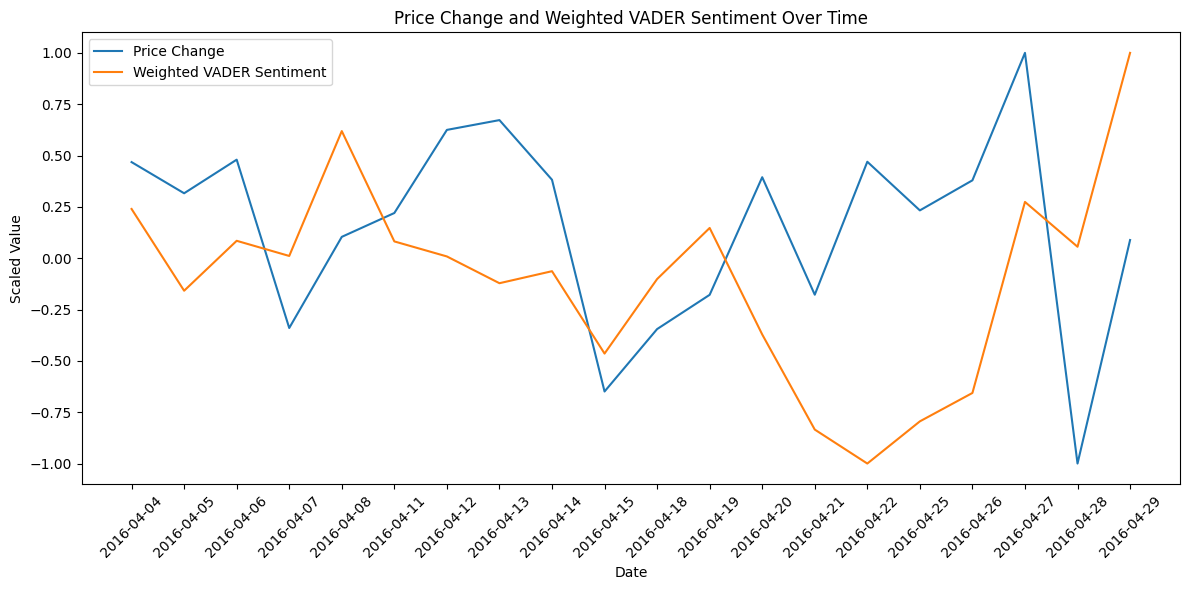

In [ ]:

#@title Relationship plot (-1, 1)

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Price Change'], label='Price Change')
plt.plot(merged_df['Date'], merged_df['Weighted VADER Sentiment'], label='Weighted VADER Sentiment')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Price Change and Weighted VADER Sentiment Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

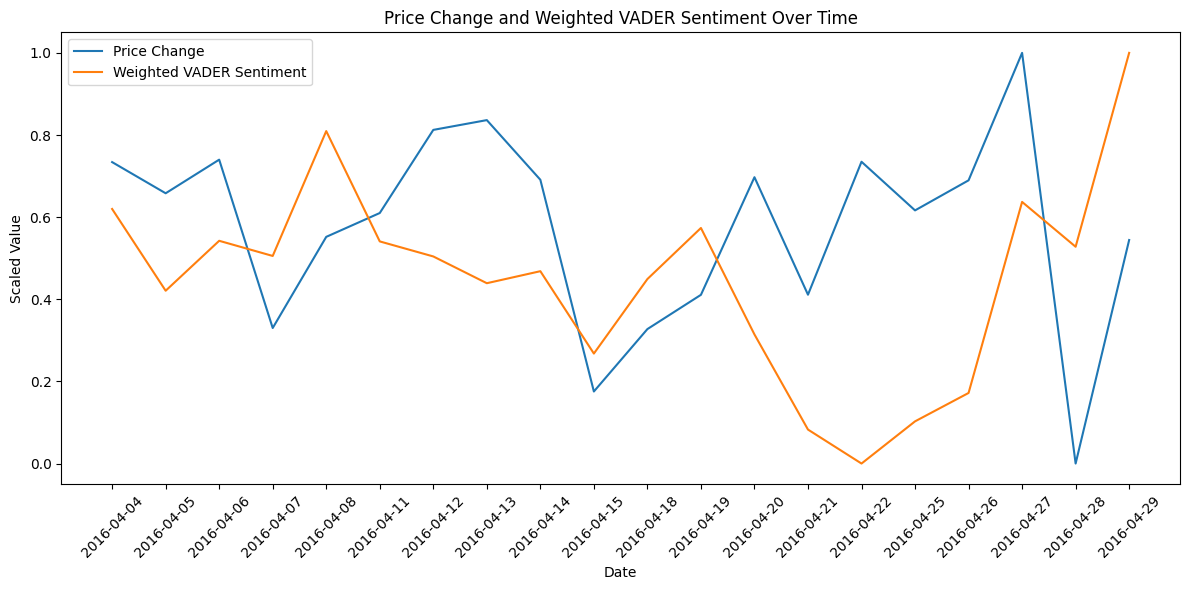

In [ ]:
#@title Relationship plot2 (0, 1)

plt.figure(figsize=(12, 6))
# Use the original merged_df2 DataFrame which contains the 'Date' column
plt.plot(merged_df2['Date'], scaled_df['Price Change'], label='Price Change')
plt.plot(merged_df2['Date'], scaled_df['Weighted VADER Sentiment'], label='Weighted VADER Sentiment')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Price Change and Weighted VADER Sentiment Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
#@title Model Building

In [ ]:
#@title LSTM

# Define a function to create input sequences for LSTM
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Convert the data to NumPy array and create sequences
data = merged_df[['Price Change', 'Weighted VADER Sentiment']].values
seq_length = 7
X, y = create_sequences(data, seq_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Model Training
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.1, verbose=1)
history

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3467 - val_loss: 0.6915
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.3419 - val_loss: 0.6876
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3402 - val_loss: 0.6837
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3381 - val_loss: 0.6792
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3370 - val_loss: 0.6731
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3339 - val_loss: 0.6662
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3328 - val_loss: 0.6607
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3341 - val_loss: 0.6539
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3255 - val_loss: 0.6478
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3268 - val_loss: 0.6411
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3202 - val_loss: 0.6344
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3261 - val_loss: 0.6269
Ep

In [ ]:
#@title Model Evaluation and Prediction

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


array([[ 0.0734839 ],
       [-0.7724137 ],
       [ 0.03690341]], dtype=float32)

In [ ]:
# Inverse scaling to get the original values
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1)], axis=1))[:, 1]
y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], 1)), y_pred], axis=1))[:, 1]

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 0.030673866704769893
R-squared: 0.8581456903475088


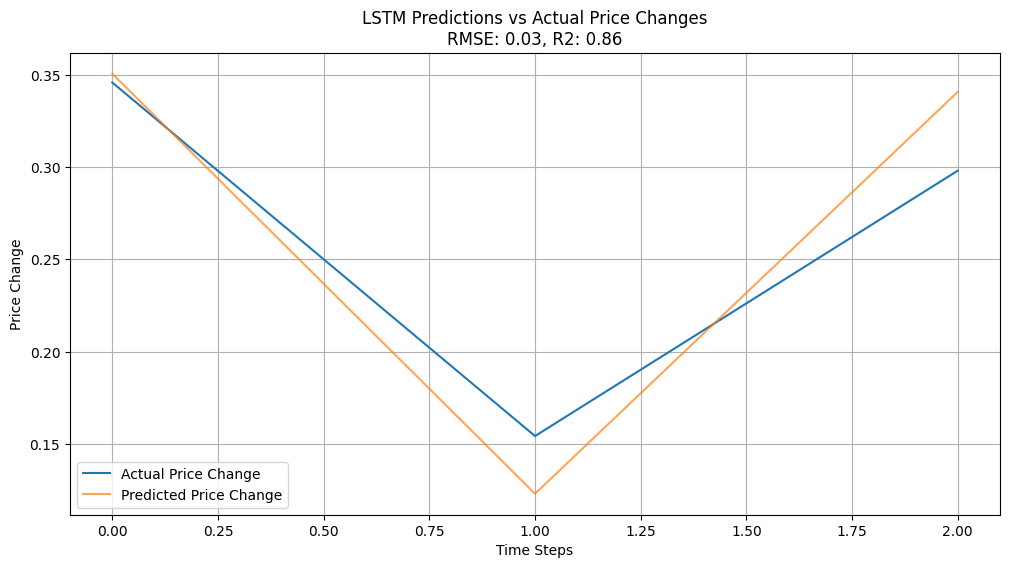

In [ ]:
# Plotting the predicted vs actual price changes
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price Change')
plt.plot(y_pred_inv, label='Predicted Price Change', alpha=0.7)
plt.title(f'LSTM Predictions vs Actual Price Changes\nRMSE: {rmse:.2f}, R2: {r2:.2f}')
plt.xlabel('Time Steps')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.show()

### Using the Scaled between (0, 1) to Build and Evaluate the Model

In [ ]:
# Define a function to create input sequences for LSTM
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

# Convert the data to NumPy array and create sequences
data = scaled_df[['Price Change', 'Weighted VADER Sentiment']].values
seq_length = 7
X, y = create_sequences(data, seq_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Model Training
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.1, verbose=1)
history

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2778 - val_loss: 0.0060
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2571 - val_loss: 0.0041
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2456 - val_loss: 0.0027
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2319 - val_loss: 0.0014
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2178 - val_loss: 4.3016e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2083 - val_loss: 8.4172e-06
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2056 - val_loss: 2.5147e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1838 - val_loss: 0.0013
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1696 - val_loss: 0.0035
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1623 - val_loss: 0.0069
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1413 - val_loss: 0.0120
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1345 - val_los

In [ ]:
#@title Model Evaluation and Prediction

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


array([[0.4731533 ],
       [0.3993211 ],
       [0.47658083]], dtype=float32)

In [ ]:
# Inverse scaling to get the original values
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1)], axis=1))[:, 1]
y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], 1)), y_pred], axis=1))[:, 1]

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 0.03681349050688225
R-squared: 0.18270382044609756


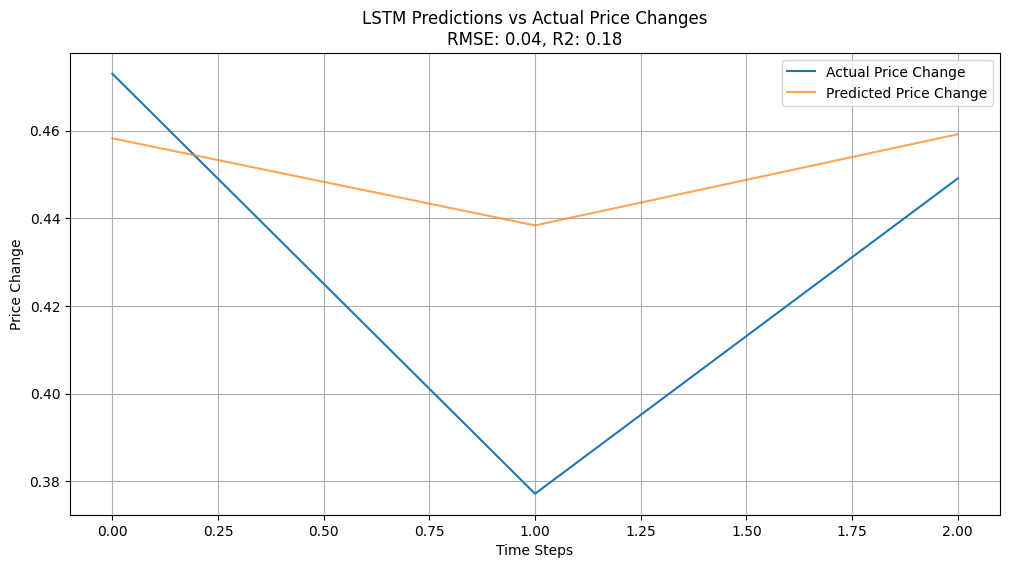

In [ ]:
# Plotting the predicted vs actual price changes
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price Change')
plt.plot(y_pred_inv, label='Predicted Price Change', alpha=0.7)
plt.title(f'LSTM Predictions vs Actual Price Changes\nRMSE: {rmse:.2f}, R2: {r2:.2f}')
plt.xlabel('Time Steps')
plt.ylabel('Price Change')
plt.legend()
plt.grid(True)
plt.show()